### 심층 신경망 훈련하기

심층 신경망 훈련 도중 다음과 같은 상황을 마주할 수 있다.

* 까다로운 그레디언트 소실 또는 그레디언트 폭주 문제에 직면할 수 있음. 심층 신경망 아래쪽으로 갈수록 그레디언트가 점점 작아지거나 커지는 현상

* 대규모 신경망을 훈련하기 위한 데이터가 충분치 않거나 레이블을 만드는데 비용이 많이 듬

* 훈련이 극단적으로 느려짐

* 수백만개의 파라미터를 가진 모델은 과적합될 수 있음

### 그레디언트 소실, 폭주 문제

역전파 알고리즘이 하위층으로 진행될수록 그레디언트가 작아지거나 커지는 현상은 훈련을 어렵게 한다.

의심되는 원인으로서 많이 사용되는 로지스틱 시그모이드 활성화 함수와, 표준정규분포 가중치 초기화 방법이 거론된다.

로지스틱 함수는 입력인 양수나 음수로 커지면 기울기가 0에 매우 가까워진다.

역전파가 될 때, 전달될 그레디언트가 거의 없고, 조금 있는 그레디언트는 최상위층으로부터 진행되며 점점 약해진다.

#### 가중치 초기화 방법

로지스틱 함수를 이용할 때, 각 층의 연결 가중치를 아래의 식대로 무작위로 초기화하면 그레디언트 문제를 완화할 수 있다.

이를 Xavier initialization라고 한다.

$$ \text{Normal distribution with mean 0 and sd } \sigma = \sqrt{\frac{1}{fan_{\mathrm{avg}}}} $$
$$ \text{ or a uniform distribution between } -r \text{ and } r, \text{ with } r = \sqrt{\frac{3}{fan_{\mathrm{avg}}}} $$

여기서 $fan_{\mathrm{avg}}$은 층의 입력과 출력의 연결 개수인 $fan_{\mathrm{in}}$과 $fan_{\mathrm{out}}$의 평균이다.

그 외에 다음과 같은 초기화 전략들이 있다.

  
| 초기화 전략 | 활성화 함수 | 정규분포 분산 |
|--|--|--|
| Glorot | 활성화 함수 없음, 하이퍼볼릭 탄젠트, 로지스틱, 소프트맥스 | $1/fan_{\mathrm{avg}}$ |
| He | ReLu 함수와 그 변종들 | $2 / fan_{\mathrm{in}}$ |
| LuCun | SELU | $1/fan_{\mathrm{in}}$ |

케라스는 기본적으로 균등분포의 글로럿 초기화를 사용한다. 

다음과 같이 층을 만들 때, ```kernerl_initializer="he_uniform"```로 바꾸어 쓸 수 있다. 

``` keras.layer.Dense(10, activation="relu", kernel_initializer="he_normal")```


#### 활성화 함수 문제

활성화 함수를 잘못 선택하면 그레디언트 소실이나 폭주로 이어질 수 있다.

초기에는 생물학적 뉴런과 비슷한 시그모이드 함수가 잘 작동할 것이라고 생각되었지만, ReLu 같은 활성화 함수가 심층 신경망에서 더 잘 작동하는 경향이 있다.

하지만 ReLu도 완벽하지 않고, 죽은 ReLu 문제가 알려져 있다.

훈련 중 일부 뉴런이 0만 출력하는 현상이다.

이 문제를 해결하기 위해 LeakyReLu, ELU, SELU 같은 변종을 사용한다.

$$ \mathrm{LeakyReLu}_{\alpha}(z) = \max(\alpha z, z) $$

$$ \mathrm{ELU}_{\alpha}(z) = 
\left\{ \begin{array}{ll} \alpha (\exp(z) - 1) & z < 0 \\
z & z \geq 0 \end{array} \right.
$$

케라스에서 LeakyReLu를 사용하려면 다음과 같이 코드를 작성한다.

```
model = keras.models.Sequential([
  [...]
  keras.layers.Dense(10, kernel_initializer="he_normal"),
  keras.layers.LeakyReLU(alpha=0.2)
  [...]
])
```

SELU 함수를 사용하려면 다음과 같이 코드를 작성한다.

``` lyaer = keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal") ```

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [3]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [4]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [5]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.6732 - accuracy: 0.4635 - val_loss: 0.8688 - val_accuracy: 0.7284
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.8265 - accuracy: 0.7329 - val_loss: 0.6980 - val_accuracy: 0.7750
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6852 - accuracy: 0.7757 - val_loss: 0.6238 - val_accuracy: 0.8006
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6227 - accuracy: 0.7942 - val_loss: 0.5794 - val_accuracy: 0.8102
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5779 - accuracy: 0.8088 - val_loss: 0.5471 - val_accuracy: 0.8238
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5576 - accuracy: 0.8145 - val_loss: 0.5254 - val_accuracy: 0.8290
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5269 - accuracy: 0.8219 - val_loss: 0.5112 - val_accuracy:

In [6]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [7]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [8]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 1.6295 - accuracy: 0.5179 - val_loss: 0.8908 - val_accuracy: 0.7294
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8423 - accuracy: 0.7389 - val_loss: 0.7133 - val_accuracy: 0.7762
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7086 - accuracy: 0.7737 - val_loss: 0.6355 - val_accuracy: 0.7962
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6340 - accuracy: 0.7939 - val_loss: 0.5920 - val_accuracy: 0.8060
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5918 - accuracy: 0.8090 - val_loss: 0.5553 - val_accuracy: 0.8200
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5604 - accuracy: 0.8149 - val_loss: 0.5347 - val_accuracy: 0.8248
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5392 - accuracy: 0.8224 - val_loss: 0.5181 - val_accuracy:

#### 배치 정규화

각 층에서 활성화 함수를 통과하기 전이나 후에 정규화 연산을 추가한다.

이 연산은 단순히 입력을 원점에 맞추어 정규화한 다음, 각 층에서 두 개의 새로운 파라미터로 결과값을 스케일링하고 이동시킨다.

미니배치별 배치정규화층에 사용될 입력값의 표본평균과 표본표준편차를 계산한다.

평균과 표준편차를 이용하여 입력값을 정규화한다. 

배치정규화층에는 스케일 파라미터 $\mathbf{\gamma}$와 오프셋 파라미터 $\mathbf{\beta}$가 있어 이를 이용해 배치 정규화 출력값을 계산한다.

$$ \mathbf{\gamma} \circ \mathbf{\hat x} + \mathbf{\beta} $$

배치정규화는 신경망의 성능을 크게 향상시킨다고 알려져 있다.

케라스에서는 다음의 코드로 배치 정규화를 구현한다.

In [9]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_6 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

In [11]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [12]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [13]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 3ms/step - loss: 1.2209 - accuracy: 0.6011 - val_loss: 0.5620 - val_accuracy: 0.8118
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5994 - accuracy: 0.7982 - val_loss: 0.4850 - val_accuracy: 0.8360
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5302 - accuracy: 0.8137 - val_loss: 0.4486 - val_accuracy: 0.8448
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4868 - accuracy: 0.8298 - val_loss: 0.4268 - val_accuracy: 0.8516
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4642 - accuracy: 0.8379 - val_loss: 0.4100 - val_accuracy: 0.8590
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4431 - accuracy: 0.8470 - val_loss: 0.3981 - val_accuracy: 0.8608
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4221 - accuracy: 0.8504 - val_loss: 0.3887 - val_accuracy:

In [14]:
#### 활성화 함수 전에 사용하는 방법


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [16]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 1.4018 - accuracy: 0.5492 - val_loss: 0.6750 - val_accuracy: 0.7888
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7119 - accuracy: 0.7755 - val_loss: 0.5512 - val_accuracy: 0.8206
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6156 - accuracy: 0.7962 - val_loss: 0.4932 - val_accuracy: 0.8360
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5583 - accuracy: 0.8117 - val_loss: 0.4594 - val_accuracy: 0.8460
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5222 - accuracy: 0.8224 - val_loss: 0.4363 - val_accuracy: 0.8534
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4905 - accuracy: 0.8344 - val_loss: 0.4191 - val_accuracy: 0.8598
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4797 - accuracy: 0.8340 - val_loss: 0.4060 - val_accuracy:

#### 그레이디언트 클리핑

그레디언트 폭주 문제를 완화하는 방법으로 역전파 수행 시 그레디언트가 일정 임계값을 넘지 못하도록 하는 것이다.

```optimizer = keras.optimizers.SGD(clipvalue=1.0)```

```optimizer = keras.optimizers.SGD(clipnorm=1.0)```

### 훈련된 층 재사용 하기

아주 큰 DNN을 처음부터 훈련하는 것인 시간이 오래 걸리기 때문에 비슷한 유형의 문제를 처리한 신경망의 하위층을 재사용할 수 있다.

(상위 층은 덜 유용함)

이를 전이 학습 (transfer learning)이라 한다.

먼저 재사용 층의 가중치들을 동결한다.

그 다음 모델을 학습하고 평가한다.

맨 위 한 두개의 은닉층의 동결을 해제하고 역전파를 통해 가중치를 조정하여 성능이 향상되는지 확인한다.

#### 케라스를 이용한 전이 학습

패션 MNIST 훈련 세트를 두 개로 나눈다.

* X_train_A: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지
* X_train_B: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트


A 세트(8개의 클래스를 가진 분류 문제)에서 모델을 훈련하고 이를 재사용하여 B 세트(이진 분류)를 해결해 보자. 

A 세트의 클래스(스니커즈, 앵클 부츠, 코트, 티셔츠 등)가 B 세트에 있는 클래스(샌달과 셔츠)와 조금 비슷함. 

In [17]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [18]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [19]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [20]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.9472 - accuracy: 0.6941 - val_loss: 0.3862 - val_accuracy: 0.8710
Epoch 2/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3795 - accuracy: 0.8743 - val_loss: 0.3306 - val_accuracy: 0.8866
Epoch 3/20
1375/1375 [==============================] - 3s 3ms/step - loss: 0.3262 - accuracy: 0.8880 - val_loss: 0.3035 - val_accuracy: 0.8976
Epoch 4/20
1375/1375 [==============================] - 3s 3ms/step - loss: 0.3036 - accuracy: 0.8942 - val_loss: 0.2929 - val_accuracy: 0.8989
Epoch 5/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2942 - accuracy: 0.8983 - val_loss: 0.2858 - val_accuracy: 0.9026
Epoch 6/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2801 - accuracy: 0.9038 - val_loss: 0.2721 - val_accuracy: 0.9101
Epoch 7/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2692 - accuracy: 0.9064 - val_loss: 0.2698 - val_accuracy:

In [21]:
model_A.save("my_model_A.h5")

model B는 자체 훈련으로 생성

In [22]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [23]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [24]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 49ms/step - loss: 0.7934 - accuracy: 0.4846 - val_loss: 0.6057 - val_accuracy: 0.6998
Epoch 2/20
7/7 [==============================] - 0s 21ms/step - loss: 0.5309 - accuracy: 0.7613 - val_loss: 0.4777 - val_accuracy: 0.7921
Epoch 3/20
7/7 [==============================] - 0s 23ms/step - loss: 0.4225 - accuracy: 0.8368 - val_loss: 0.3986 - val_accuracy: 0.8580
Epoch 4/20
7/7 [==============================] - 0s 28ms/step - loss: 0.3491 - accuracy: 0.8976 - val_loss: 0.3428 - val_accuracy: 0.8935
Epoch 5/20
7/7 [==============================] - 0s 24ms/step - loss: 0.2775 - accuracy: 0.9400 - val_loss: 0.3007 - val_accuracy: 0.9148
Epoch 6/20
7/7 [==============================] - 0s 24ms/step - loss: 0.2315 - accuracy: 0.9649 - val_loss: 0.2697 - val_accuracy: 0.9260
Epoch 7/20
7/7 [==============================] - 0s 25ms/step - loss: 0.2211 - accuracy: 0.9570 - val_loss: 0.2442 - val_accuracy: 0.9351
Epoch 8/20
7/7 [===========

In [25]:
model_B.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_19 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_20 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_21 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_22 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                

model_A와 model_B_on_A는 일부 층을 공유한다.

In [26]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

model_B_on_A를 훈련할 때 model_A도 영향을 받는다. 이를 원치 않으면 ```clone_model()``` 메쏘드로 구조를 복제한 뒤 가중치를 복사해둔다.

In [27]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

이제 model_B_on_A를 훈련할 수 있는데, 새로운 출력층이 랜덤하게 초기화되었으므로, 큰 오차를 생성할 수 있음.

큰 오차 그레디언트가 재사용된 가중치를 망치지 않도록, 처음 몇 번의 에포크 동안은 재사용된 층을 동결하고 새로운 층에 적절한 가중치를 학습할 시간을 준다.

In [28]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

모델을 몇번 훈련하고, 재사용된 층의 동결을 해제한 뒤, 다시 컴파일한 다음, 훈련을 계속한다.

일반적으로 재사용된 층의 동결을 해제한 후 학습률을 낮추는 것이 좋다.

In [29]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 57ms/step - loss: 0.7041 - accuracy: 0.5990 - val_loss: 0.6643 - val_accuracy: 0.6379
Epoch 2/4
7/7 [==============================] - 0s 18ms/step - loss: 0.6278 - accuracy: 0.6544 - val_loss: 0.6176 - val_accuracy: 0.6521
Epoch 3/4
7/7 [==============================] - 0s 23ms/step - loss: 0.5790 - accuracy: 0.6614 - val_loss: 0.5741 - val_accuracy: 0.6765
Epoch 4/4
7/7 [==============================] - 0s 38ms/step - loss: 0.5169 - accuracy: 0.7047 - val_loss: 0.5361 - val_accuracy: 0.6897
Epoch 1/16
7/7 [==============================] - 1s 61ms/step - loss: 0.4127 - accuracy: 0.8063 - val_loss: 0.2890 - val_accuracy: 0.9391
Epoch 2/16
7/7 [==============================] - 0s 18ms/step - loss: 0.2464 - accuracy: 0.9479 - val_loss: 0.2178 - val_accuracy: 0.9675
Epoch 3/16
7/7 [==============================] - 0s 16ms/step - loss: 0.1809 - accuracy: 0.9819 - val_loss: 0.1802 - val_accuracy: 0.9736
Epoch 4/16
7/7 [===============

In [30]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1198 - accuracy: 0.9740


[0.11978120356798172, 0.9739999771118164]

In [31]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.0653 - accuracy: 0.9945


[0.06532242894172668, 0.9944999814033508]

### 고속 옵티마이저

#### 모멘텀 옵티마이저

In [32]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

#### 네스테로프 가속 경사

In [33]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

#### AdaGrad

In [34]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

#### RMSProp

In [35]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

#### Adam 옵티마이저

In [36]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

#### Adamax 옵티마이저

In [37]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

#### Nadam 옵티마이저

In [38]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

### 학습률 스케쥴링

학습률을 너무 크게 잡으면 훈련이 발산할 수 있고, 너무 작게 잡으면 수렴 시간이 오래 걸릴 것이다.

큰 학습률로 시작하고 학습 속도가 느려질 때 학습률을 낮추는 전략을 취할 수 있다.

훈련하는 동안 학습률을 감소시키는 학습 스케쥴에는 여러가지가 있다.

#### 거듭제곱 기반 스케쥴링

$$lr = \frac{lr0}{(1 + steps / s)^c}$$

거듭제곱 스케쥴링은 옵티마이저를 만들 때 ```decay``` (s의 역수) 만 설정해 주면 된다. c=1임.

In [39]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [40]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [41]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [42]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6068 - accuracy: 0.7892 - val_loss: 0.4144 - val_accuracy: 0.8606
Epoch 2/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3857 - accuracy: 0.8639 - val_loss: 0.3815 - val_accuracy: 0.8658
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3462 - accuracy: 0.8768 - val_loss: 0.3625 - val_accuracy: 0.8728
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3247 - accuracy: 0.8847 - val_loss: 0.3522 - val_accuracy: 0.8766
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3067 - accuracy: 0.8913 - val_loss: 0.3451 - val_accuracy: 0.8788
Epoch 6/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2979 - accuracy: 0.8927 - val_loss: 0.3417 - val_accuracy: 0.8830
Epoch 7/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2883 - accuracy: 0.8984 - val_loss: 0.3437 - val_accuracy:

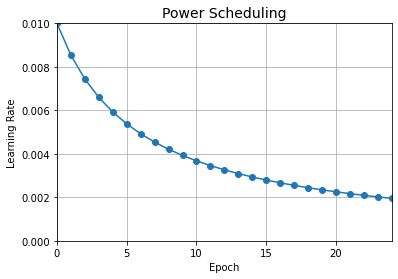

In [43]:
import math
import matplotlib.pyplot as plt

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

#### 지수 기반 스케쥴링

```lr = lr0 * 0.1**(epoch / s)```

In [44]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [45]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [46]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 12s 6ms/step - loss: 1.1843 - accuracy: 0.7133 - val_loss: 1.0511 - val_accuracy: 0.6774
Epoch 2/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8213 - accuracy: 0.7070 - val_loss: 1.0220 - val_accuracy: 0.6812
Epoch 3/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.7461 - accuracy: 0.7258 - val_loss: 0.7836 - val_accuracy: 0.7120
Epoch 4/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.7095 - accuracy: 0.7358 - val_loss: 0.7549 - val_accuracy: 0.7502
Epoch 5/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6266 - accuracy: 0.7501 - val_loss: 0.6525 - val_accuracy: 0.7328
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6076 - accuracy: 0.7586 - val_loss: 0.6814 - val_accuracy: 0.7614
Epoch 7/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5492 - accuracy: 0.7702 - val_loss: 0.6625 - val_acc

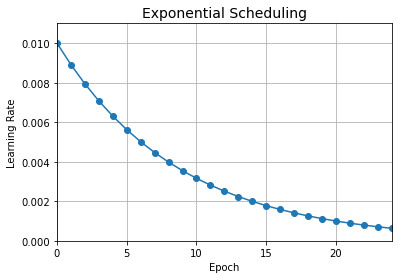

In [47]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

그 외에

* 구간별 고정 스케쥴링
* 성능 기반 스케쥴링
* 1 사이클 스케쥴링

### 규제를 통한 과대적합 피하기

#### $\ell_1$과 $\ell_2$ 규제



In [48]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [49]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 10s 6ms/step - loss: 3.3166 - accuracy: 0.7925 - val_loss: 0.7429 - val_accuracy: 0.8226
Epoch 2/2
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7353 - accuracy: 0.8212 - val_loss: 0.6830 - val_accuracy: 0.8430


#### 드롭아웃

드롭아웃은 심층 신경망에서 인기 있는 규제로 잘 작동된다고 입증되었다.

매 훈련 각 스텝에서 각 뉴런은 임시적으로 드롭아웃될 확률 p를 가진다.

즉, 이번 훈련에는 무시되어도 다음 훈련에서는 활성화 될 수 있다.

훈련이 끝난 후에는 드랍아웃을 적용하지 않는다.



In [50]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.7464 - accuracy: 0.7580 - val_loss: 0.3824 - val_accuracy: 0.8644
Epoch 2/2
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4303 - accuracy: 0.8414 - val_loss: 0.3513 - val_accuracy: 0.8700
